In [1]:
import json
from StringIO import StringIO
import openpyxl
import pandas as pd
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
listings = pd.read_csv('Datasources/listings_augmented/listings_augmented_2018-05-23_V5.csv', low_memory = False)
#ALWAYS REMOVE THESE ROWS WHENEVER IMPORTING LISTINGS -- NB: THESE ROWS MIGHT VARY BASED ON NEW DATAPREP RUN
listings = listings.drop(listings.index[4216:4219])

In [3]:
listings.index = [i for i in range(len(listings))]

In [4]:
listings = listings.drop('distance_from_ocean', axis = 1)

In [5]:
contour_list = [(-117.12542727272728, 32.50603636363636),(-117.1239, 32.52068181818182),(-117.12237272727273, 32.53532727272727),(-117.12785, 32.550577272727274),
 (-117.13332727272727, 32.565827272727276),(-117.14155757575757, 32.58140454545455),(-117.14978787878788, 32.59698181818182),(-117.15801818181818, 32.61255909090909),
 (-117.14722727272728, 32.6186),(-117.13142727272728, 32.61995454545455), (-117.11562727272728, 32.621309090909094),(-117.16624848484848, 32.628136363636365),(-117.11614090909092, 32.6319),
 (-117.15394090909092, 32.632684090909095),(-117.11665454545455, 32.64249090909091),(-117.17447878787878, 32.643713636363636),(-117.16065454545455, 32.64676818181818),(-117.12490000000001, 32.6552),
 (-117.2549909090909, 32.65713636363636),(-117.18270909090909, 32.659290909090906), (-117.16736818181818, 32.66085227272727),(-117.24204545454546, 32.66253636363636),
 (-117.19277575757576, 32.66720303030303),(-117.13314545454546, 32.66790909090909),(-117.26173636363637, 32.67278181818182),(-117.24129545454545, 32.673590909090905),
 (-117.17408181818182, 32.67493636363636),(-117.20284242424242, 32.67511515151515),(-117.14139090909092, 32.68061818181818), (-117.2129090909091, 32.68302727272727),(-117.24054545454545, 32.68464545454545),
 (-117.18729545454545, 32.686263636363634), (-117.26848181818183, 32.688427272727274), (-117.15354363636364, 32.690034545454544),
 (-117.21238181818183, 32.69705454545455), (-117.2005090909091, 32.69759090909091), (-117.26729545454546, 32.698513636363636),
 (-117.16569636363637, 32.699450909090906), (-117.23467727272728, 32.700131818181816), (-117.2661090909091, 32.7086),
 (-117.17784909090909, 32.708867272727275), (-117.2288090909091, 32.71561818181818), (-117.19000181818183, 32.71828363636364),
 (-117.21548181818181, 32.721659090909085), (-117.26427272727273, 32.72405454545454), (-117.20215454545455, 32.7277), (-117.26243636363637, 32.73950909090909),
 (-117.26060000000001, 32.754963636363634), (-117.25876363636364, 32.77041818181818), (-117.26415909090909, 32.78511818181818),
 (-117.26955454545455, 32.79981818181818), (-117.27495, 32.81451818181819), (-117.28034545454545, 32.829218181818185), (-117.27120303030303, 32.83975454545455),
 (-117.26206060606061, 32.85029090909091), (-117.25291818181819, 32.86082727272727), (-117.24906363636364, 32.87129090909091),
 (-117.24953181818182, 32.88050454545454), (-117.25, 32.88971818181818), (-117.25397272727272, 32.90718909090909), (-117.25794545454545, 32.92466),
 (-117.26191818181819, 32.942130909090906), (-117.26589090909091, 32.95960181818182), (-117.26986363636364, 32.97707272727273),
 (-117.27609772727273, 32.993097727272726), (-117.28233181818182, 33.009122727272725), (-117.2885659090909, 33.025147727272724),
 (-117.29480000000001, 33.04117272727272), (-117.3010340909091, 33.05719772727273), (-117.30726818181819, 33.07322272727273), (-117.31350227272728, 33.08924772727273)]

In [6]:
def search_for_min_index(L, x):
    B = []
    count = 0
    for i, j in L:
        J = float(j)
        X = float(x)
        b = abs(J - X)
        B.append((count, b))
        count = count + 1
        
    B = sorted(B, key = lambda x: x[1])
    return (B[0][0], B[1][0])
        

In [7]:
lst2 = []
for i,k in zip(listings['latitude'], listings['longitude']):
    j_one, j_two = search_for_min_index(contour_list, i)
    val_one_i, val_one_ii = contour_list[j_one]
    val_two_i, val_two_ii = contour_list[j_two]
    val_ii_max = max(val_one_ii, val_two_ii)
    val_ii_min = min(val_one_ii, val_two_ii)
        
    #rat = (i - val_ii_min)/val_ii_max
    #val_i_max = max(val_one_i, val_two_i)
    #val_i_min = min(val_one_i, val_two_i)
    #val_i = val_i_min*rat + val_i_max*(1 - rat)
        
    lon_diff = (float(k) - val_one_i)*np.pi/180
    lat_diff = (float(i) - val_one_ii)*np.pi/180
    a = np.sin(lat_diff/2)**2 + np.cos(float(i)*np.pi/180)*np.cos(val_one_ii*np.pi/180)*(np.sin(lon_diff/2)**2)
    c_one = np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d_one = 6371.00*float(c_one)
        
    lon_diff = (float(k) - val_two_i)*np.pi/180
    lat_diff = (float(i) - val_two_ii)*np.pi/180
    a = np.sin(lat_diff/2)**2 + np.cos(float(i)*np.pi/180)*np.cos(val_two_ii*np.pi/180)*(np.sin(lon_diff/2)**2)
    c_two = np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d_two = 6371.00*float(c_two)
        
    #lon_diff = (float(k) - val_i)*np.pi/180
    #a = (np.cos(float(i)*np.pi/180)**2)*(np.sin(lon_diff/2)**2)
    #c_three = np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    #d_three = 6371.00*float(c_three)
    #d = min(d_one, d_two, d_three)
        
    d = min(d_one, d_two)
    lst2.append(d)
        
listings['distance_from_ocean'] = lst2

In [8]:
listings_augmented_numeric = listings.select_dtypes(include=['float64', 'int64'])

In [9]:
listings_augmented_numeric = listings_augmented_numeric.fillna(listings_augmented_numeric)

In [10]:
listings_augmented_numeric = listings_augmented_numeric.fillna(listings_augmented_numeric.mean())

In [11]:
listings_augmented_numeric = listings_augmented_numeric.dropna(1)

In [12]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(listings_augmented_numeric)

In [13]:
kmeans.labels_

array([2, 0, 1, ..., 0, 2, 2])

In [14]:
class_cluster_dictionary = {}

for i in range(10):
    class_cluster_dictionary[i] = []

In [15]:
for i in range(len(listings_augmented_numeric)):
    key = kmeans.labels_[i]
    v = listings_augmented_numeric['listing_id_x'][i]
    
    class_cluster_dictionary[key].append(v)

In [16]:
colors = kmeans.labels_

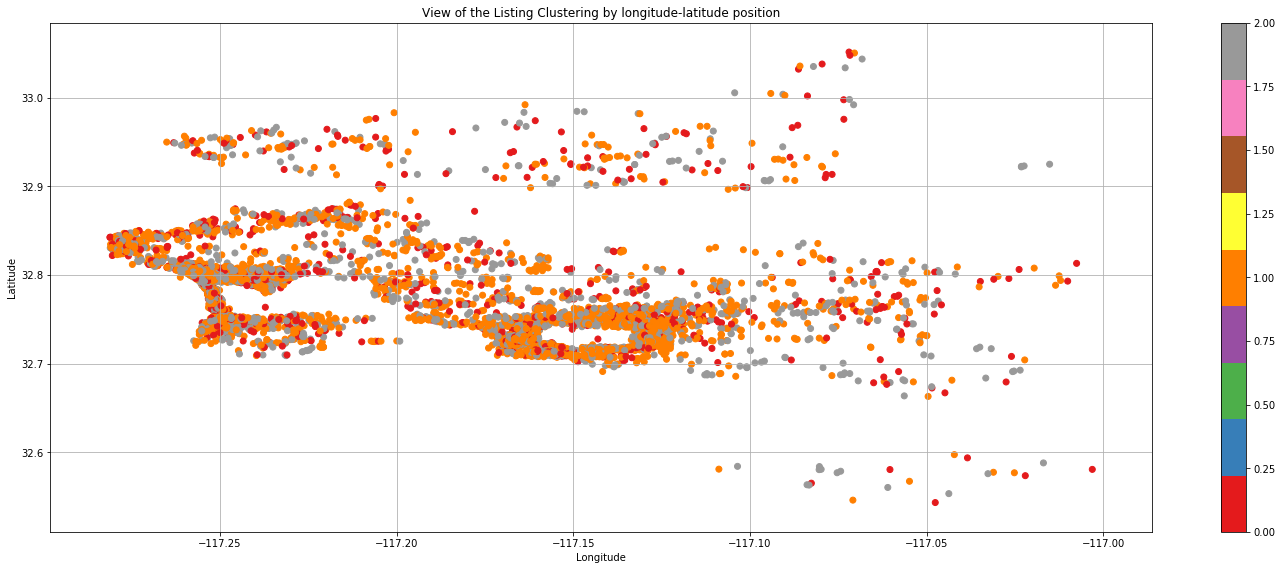

In [17]:
fig, ax = plt.subplots(figsize = (20, 8))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], 
               c = colors, cmap = 'Set1')
fig.colorbar(l)
#ax.set_xlim((listings_augmented_numeric['longitude'].min() - .1, -116.8))
#ax.set_ylim((32, listings_augmented_numeric['latitude'].max() + .1))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('View of the Listing Clustering by longitude-latitude position')
fig.tight_layout(pad = 1)
ax.grid(True)
plt.show()

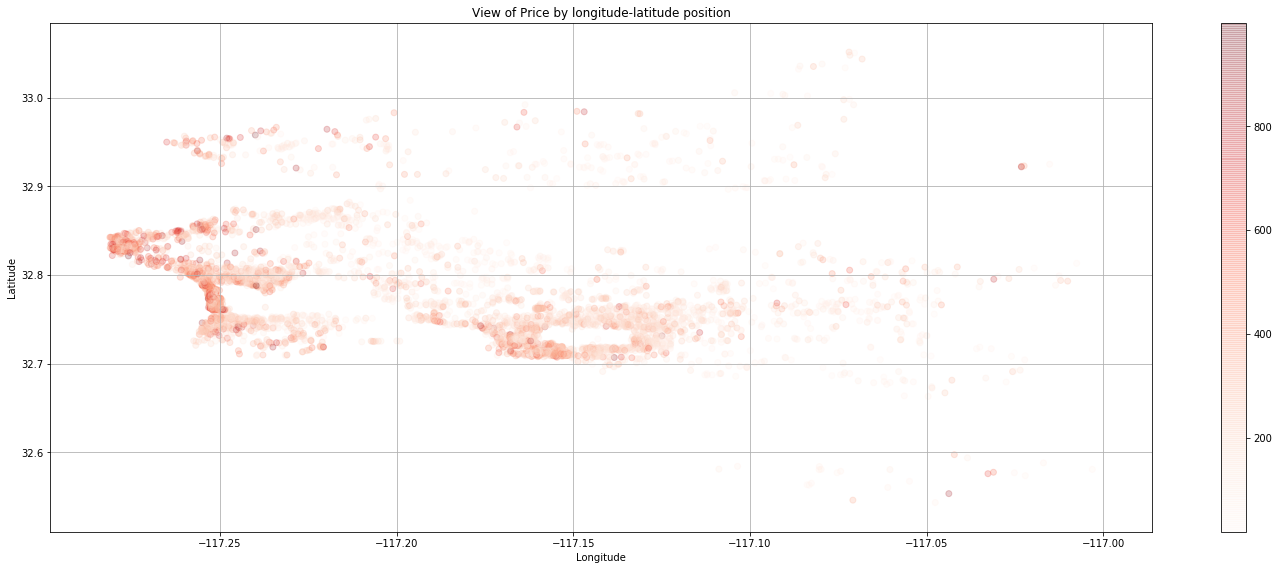

In [18]:
fig, ax = plt.subplots(figsize = (20, 8))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'],
               c = listings_augmented_numeric['price_y'], cmap = 'Reds', alpha=0.2)
fig.colorbar(l)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('View of Price by longitude-latitude position')
fig.tight_layout(pad = 1)
ax.grid(True)
plt.show()

In [19]:
listings['cancellation_policy'].unique()

array(['moderate', 'strict', 'flexible', 'super_strict_60',
       'super_strict_30', 'no_refunds'], dtype=object)

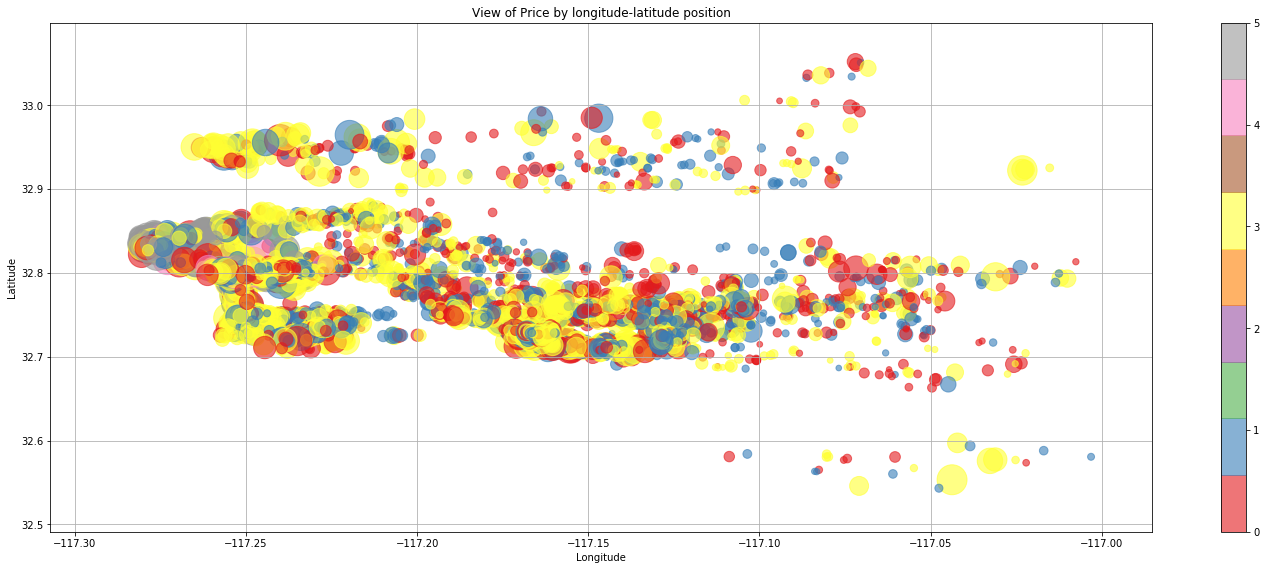

In [20]:
#IF YOU WANT TO USE CATEGORICAL FEATURES, THOSE HAVE ALREADY BEEN ENCODED/BINARIZED FOR YOU
#JUST APPEND _enc AT THE END OF THE COL NAME, OR _bin IF IT'S A BINARY FEATURE
fig, ax = plt.subplots(figsize = (20, 8))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], 
               s = listings_augmented_numeric['price_y'], c = listings_augmented_numeric['cancellation_policy_enc'],
              cmap= 'Set1', alpha=0.6)
fig.colorbar(l)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('View of Price by longitude-latitude position')
fig.tight_layout(pad = 1)
ax.grid(True)
plt.show()

In [21]:
# A mapping of the encoding
K = []
for w in zip(listings['cancellation_policy'], listings.cancellation_policy_enc):
    if w not in K:
        K.append(w)
K

[('moderate', 1.0),
 ('strict', 3.0),
 ('flexible', 0.0),
 ('super_strict_60', 5.0),
 ('super_strict_30', 4.0),
 ('no_refunds', 2.0)]

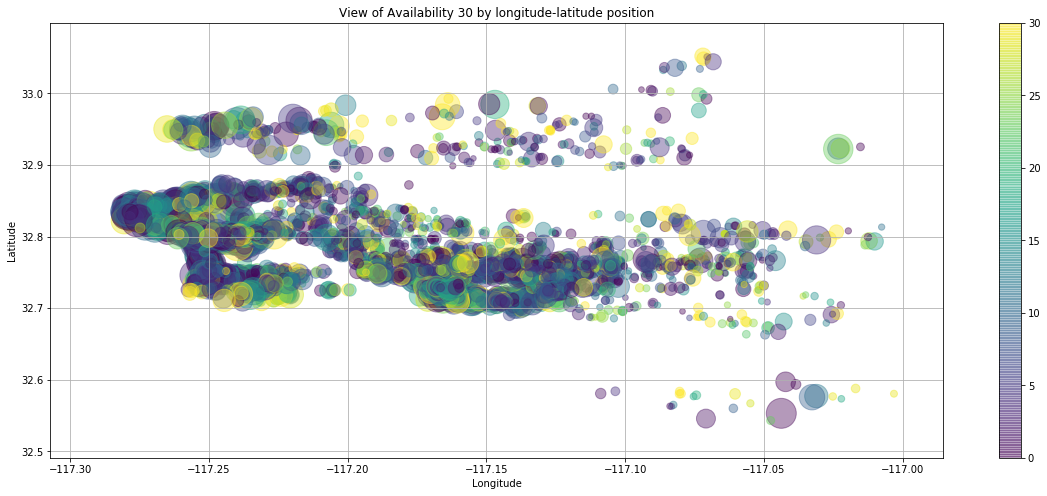

In [22]:
fig, ax = plt.subplots(figsize = (20, 8))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], 
               s = listings_augmented_numeric['price_y'], c = listings_augmented_numeric['availability_30'],
              alpha = 0.4)
fig.colorbar(l)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('View of Availability 30 by longitude-latitude position')
#fig.tight_layout(pad = 1)
ax.grid(True)
plt.show()

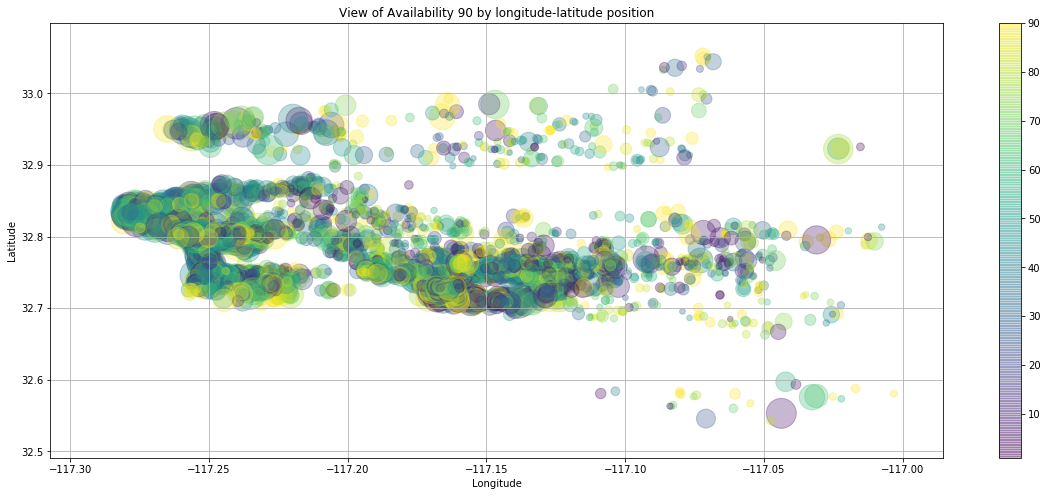

In [23]:
fig, ax = plt.subplots(figsize = (20, 8))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude']
               , s = listings_augmented_numeric['price_y'], c = listings_augmented_numeric['availability_90'],
              alpha=0.3)
fig.colorbar(l)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('View of Availability 90 by longitude-latitude position')
ax.grid(True)
plt.show()

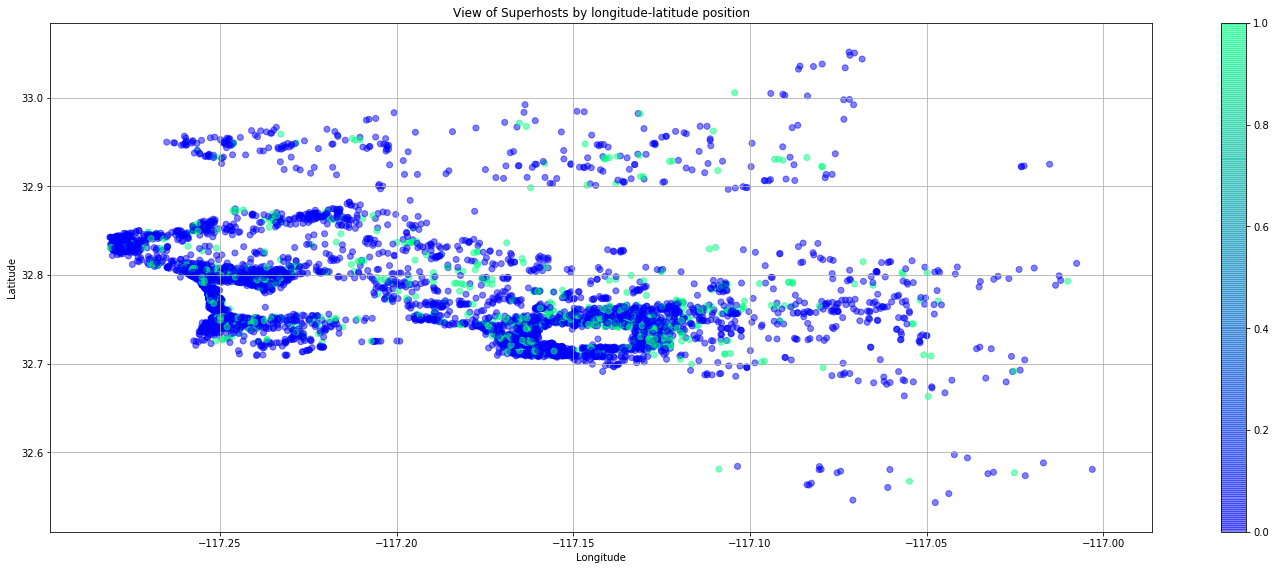

In [24]:
fig, ax = plt.subplots(figsize = (20, 8))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], 
               c = listings_augmented_numeric['host_is_superhost_bin'],
              cmap = 'winter', alpha=0.5)
fig.colorbar(l)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('View of Superhosts by longitude-latitude position')
fig.tight_layout(pad = 1)
ax.grid(True)
plt.show()

In [25]:
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(listings_augmented_numeric)

In [26]:
kmeans.labels_

array([1, 0, 1, ..., 0, 1, 1])

In [27]:
class_cluster_dictionary = {}

for i in range(2):
    class_cluster_dictionary[i] = []

In [28]:
for i in range(len(listings_augmented_numeric)):
    key = kmeans.labels_[i]
    v = listings_augmented_numeric['listing_id_x'][i]
    
    class_cluster_dictionary[key].append(v)

In [29]:
colors = kmeans.labels_

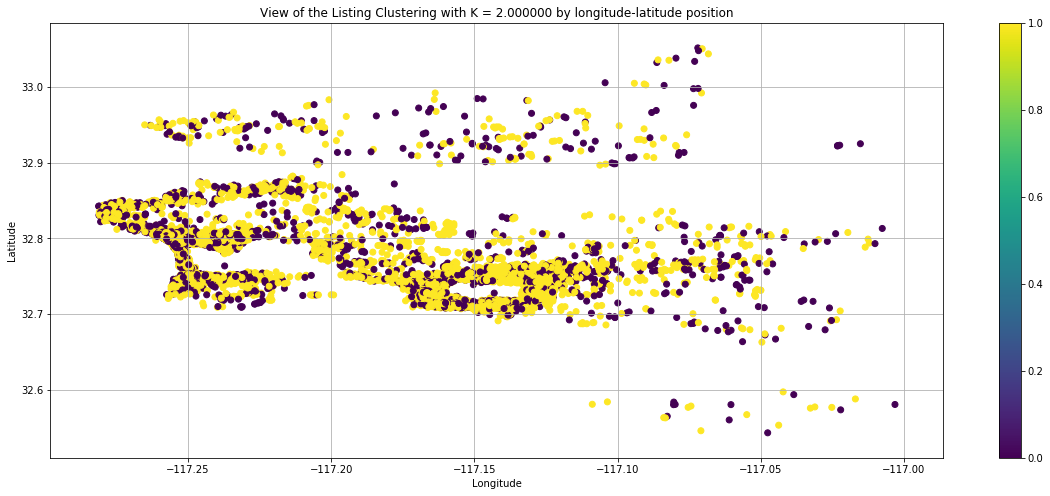

In [30]:
fig, ax = plt.subplots(figsize = (20, 8))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], 
               c = colors)
fig.colorbar(l)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('View of the Listing Clustering with K = %f by longitude-latitude position'%(int(num_clusters)))
ax.grid(True)
plt.show()

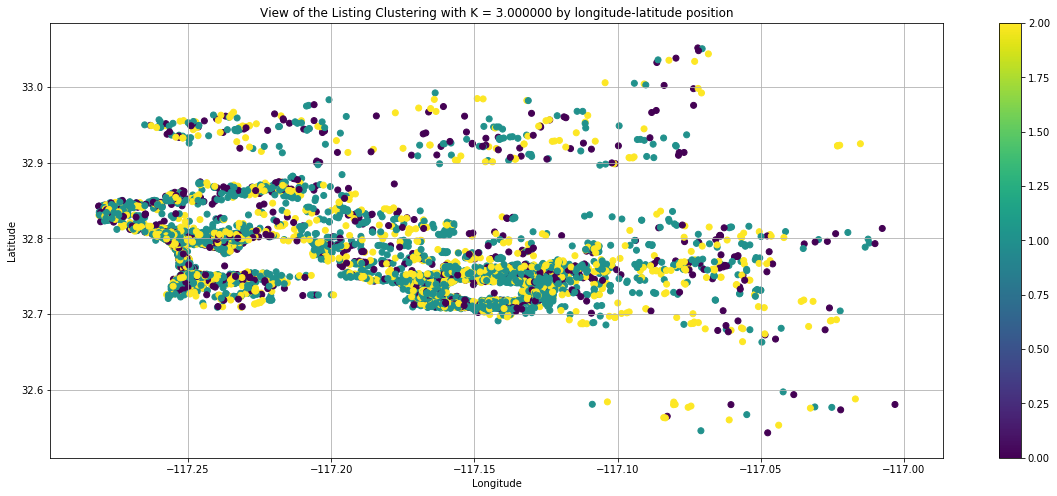

In [31]:
num_clusters = 3

kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(listings_augmented_numeric)

class_cluster_dictionary = {}

for i in range(3):
    class_cluster_dictionary[i] = []
    
for i in range(len(listings_augmented_numeric)):
    key = kmeans.labels_[i]
    v = listings_augmented_numeric['listing_id_x'][i]
    
    class_cluster_dictionary[key].append(v)
    
colors = kmeans.labels_
    
fig, ax = plt.subplots(figsize = (20, 8))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], c = colors)
fig.colorbar(l)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('View of the Listing Clustering with K = %f by longitude-latitude position'%(int(num_clusters)))
ax.grid(True)
plt.show()

In [32]:
kmeans.labels_

array([2, 0, 1, ..., 0, 2, 2])

In [33]:
kmeans.cluster_centers_

array([[  1.15704154e-02,   7.34346505e-02,   4.40729483e-03,
          9.84194529e-02,   9.01823708e-02,   1.02026342e-02,
          4.97163121e-02,   3.27355623e-02,   6.53758711e+07,
          9.30149926e+01,   9.07429234e+01,   3.27860466e+01,
         -1.17193977e+02,   4.43768997e+00,   1.56990881e+00,
          1.65957447e+00,   2.20998965e+00,   1.24462000e+03,
          5.77193570e+02,   8.41494507e+02,   2.91826510e+02,
          1.28238262e+02,   1.46909828e+00,   8.28368794e+00,
          2.21884498e+00,   7.69250253e+02,   1.11469098e+01,
          2.89696049e+01,   4.92998987e+01,   1.91396150e+02,
          2.78419453e+00,   9.48761317e+01,   9.61960283e+00,
          9.52704045e+00,   9.81175140e+00,   9.80793014e+00,
          9.68275192e+00,   9.52064658e+00,   1.00243161e+01,
          2.08590109e+00,   1.25803077e+07,   2.69345510e+02,
          2.14712013e+02,   1.81414491e+02,   2.17469278e+02,
          1.93017782e+00,   1.65159132e+02,   1.36988268e+02,
        

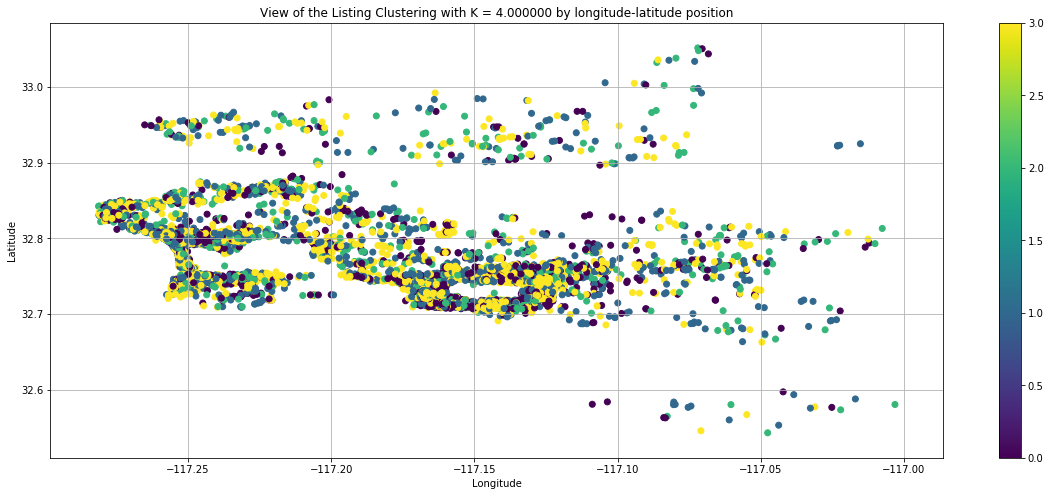

In [34]:
num_clusters = 4

kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(listings_augmented_numeric)

class_cluster_dictionary = {}

for i in range(num_clusters):
    class_cluster_dictionary[i] = []
    
for i in range(len(listings_augmented_numeric)):
    key = kmeans.labels_[i]
    v = listings_augmented_numeric['listing_id_x'][i]
    
    class_cluster_dictionary[key].append(v)
    
colors = kmeans.labels_
    
fig, ax = plt.subplots(figsize = (20, 8))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], c = colors)
fig.colorbar(l)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('View of the Listing Clustering with K = %f by longitude-latitude position'%(int(num_clusters)))
ax.grid(True)
plt.show()

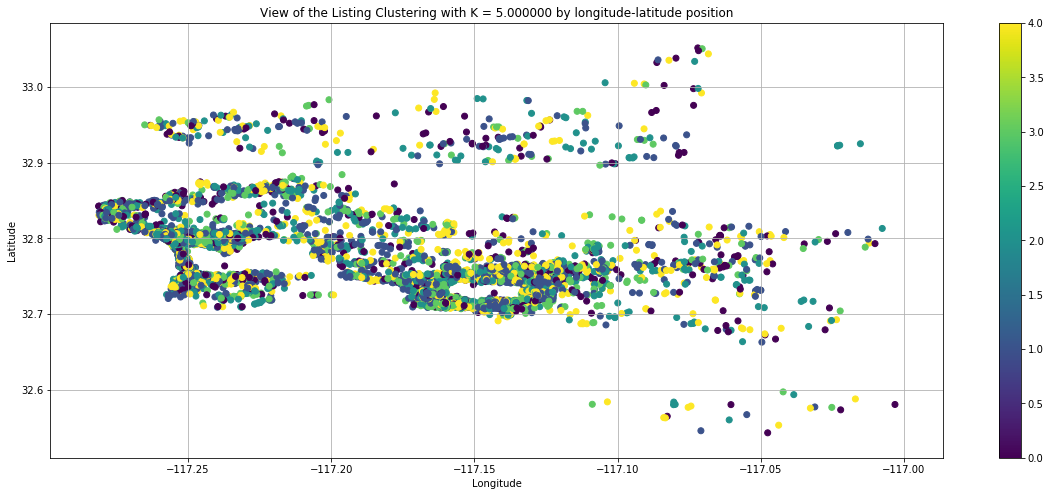

In [35]:
num_clusters = 5

kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(listings_augmented_numeric)

class_cluster_dictionary = {}

for i in range(num_clusters):
    class_cluster_dictionary[i] = []
    
for i in range(len(listings_augmented_numeric)):
    key = kmeans.labels_[i]
    v = listings_augmented_numeric['listing_id_x'][i]
    
    class_cluster_dictionary[key].append(v)
    
colors = kmeans.labels_
    
fig, ax = plt.subplots(figsize = (20, 8))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], c = colors)
fig.colorbar(l)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('View of the Listing Clustering with K = %f by longitude-latitude position'%(int(num_clusters)))
ax.grid(True)
plt.show()

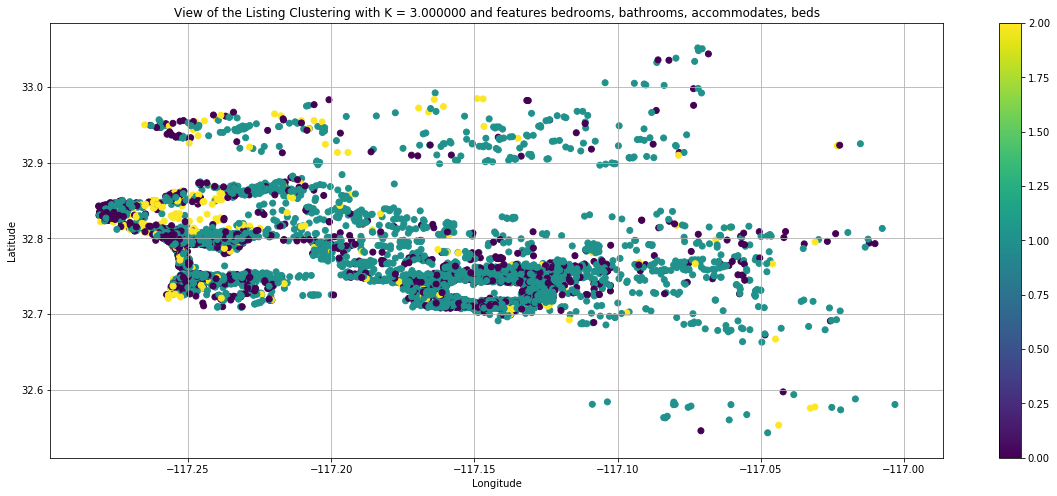

In [36]:
num_clusters = 3
features = ['bedrooms', 'bathrooms', 'accommodates', 'beds']
kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(listings_augmented_numeric[features])

class_cluster_dictionary = {}

for i in range(num_clusters):
    class_cluster_dictionary[i] = []
    
for i in range(len(listings_augmented_numeric)):
    key = kmeans.labels_[i]
    v = listings_augmented_numeric['listing_id_x'][i]
    
    class_cluster_dictionary[key].append(v)
    
colors = kmeans.labels_
    
fig, ax = plt.subplots(figsize = (20, 8))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], c = colors)
fig.colorbar(l)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('View of the Listing Clustering with K = %f and features %s'%(num_clusters, ", ".join(features)))
ax.grid(True)
plt.show()

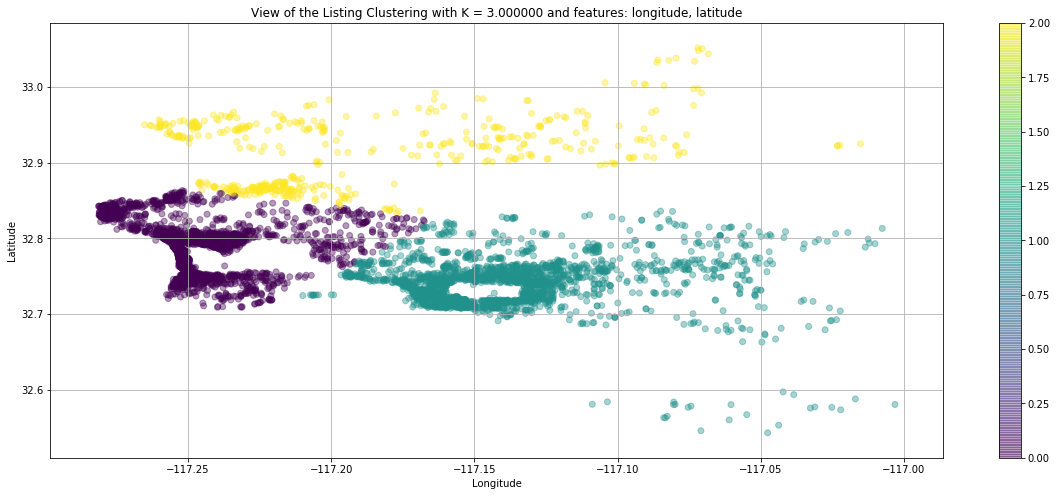

In [37]:
num_clusters = 3
features = ['longitude','latitude']
kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(listings_augmented_numeric[features])

class_cluster_dictionary = {}

for i in range(num_clusters):
    class_cluster_dictionary[i] = []
    
for i in range(len(listings_augmented_numeric)):
    key = kmeans.labels_[i]
    v = listings_augmented_numeric['listing_id_x'][i]
    
    class_cluster_dictionary[key].append(v)
    
colors = kmeans.labels_
    
fig, ax = plt.subplots(figsize = (20, 8))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], 
               c = colors, alpha=.4)
fig.colorbar(l)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('View of the Listing Clustering with K = %f and features: %s'%(num_clusters, ", ".join(features)))
ax.grid(True)
plt.show()

In [ ]:
#Was trying DBSCAN but not sure it's worth pursuing

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN

In [ ]:
distance_matrix = pairwise_distances(listings_augmented_numeric[['longitude', 'latitude']], metric='euclidean')

In [ ]:
dbscan = DBSCAN(metric='precomputed', eps=3, min_samples=10)

In [ ]:
labels = dbscan.fit_predict(distance_matrix)

In [ ]:
labels

In [ ]:
max(labels)